# Basic Version

In [116]:
import gzip
import csv
from collections import defaultdict
import random
import numpy
import matplotlib.pyplot as plt
import pandas
import scipy
import scipy.optimize

In [117]:
def readGz(path):
    for l in gzip.open(path, "rt"):
        yield eval(l)

In [118]:
def readCSV(path):
    f = gzip.open(path, "rt")
    f.readline()
    for l in f:
        yield l.strip().split(",")

In [119]:
path = "train_Interactions.csv.gz"
c = csv.reader(gzip.open(path, "rt"), delimiter=",")

In [120]:
dataset = []

In [121]:
first = True
for line in c:
    # The first line is the header
    if first:
        header = line
        first = False
    else:
        d = dict(zip(header, line))
        # Convert strings to integers for some fields:
        d["rating"] = int(d["rating"])
        dataset.append(d)

In [122]:
training = dataset[:190000]
validation = dataset[190000:]

## Qustion 1

In [64]:
# create empty dictionaries of booksPerUser and UsersPerBook
booksPerUser = defaultdict(set)
usersPerBook = defaultdict(set)

# create an empty set of books
booklist = set()

In [65]:
for d in dataset:
    user, book = d["userID"], d["bookID"]
    booksPerUser[user].add(book)
    usersPerBook[book].add(user)

    if book not in booklist:
        booklist.add(book)

In [11]:
header = ["userID", "bookID", "rating"]

for v in validation[0:10000]:

    u_id = v["userID"]

    notRead = booklist.difference(booksPerUser[u_id])
    c = random.sample(notRead, 1)
    line = [u_id, c[0], 0]
    d = dict(zip(header, line))
    validation.append(d)

In [12]:
# use Would-read baseline model
bookCount = defaultdict(int)
totalRead = 0

# for user,book,_ in readCSV("train_Interactions.csv.gz"):
for t in training:
    bookCount[t["bookID"]] += 1
    totalRead += 1

In [13]:
mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

# Get 50% most popular books
return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalRead / 2:
        break

In [14]:
predictions = open("predictions_Read.txt", "w")

header = "userID-bookID,prediction" + "\n"
predictions.write(header)

for v in validation:

    u = v["userID"]
    b = v["bookID"]

    if b in return1:
        predictions.write(u + "-" + b + ",1\n")
    else:
        predictions.write(u + "-" + b + ",0\n")

predictions.close()

In [15]:
# calculate accuracy
num_pred = 0
corr_pred = 0

for i in open("predictions_Read.txt", "r"):
    user_id, b = i.strip().split("-")
    book_id, score = b.strip().split(",")
    num_pred = num_pred + 1

    # if the book is not 50% most popular(predict: user not read)
    if score == "0":
        if book_id in booksPerUser[user_id]:
            continue
        else:
            corr_pred = corr_pred + 1

    # if the book is 50% most popular(predict: user read)
    else:
        if book_id in booksPerUser[user_id]:
            corr_pred = corr_pred + 1
        else:
            continue

acc = corr_pred / num_pred

In [16]:
acc

0.6461676916154192

## Question 2

In [17]:
accuracy = []
threshold = numpy.linspace(0.1, 0.9, 9)
for x in threshold:
    return2 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return2.add(i)
        if count > totalRead * (x):
            break

    predictions2 = open("predictions_Read2.txt", "w")

    header = "userID-bookID,prediction" + "\n"
    predictions2.write(header)

    for v in validation:

        u = v["userID"]
        b = v["bookID"]

        if b in return2:
            predictions2.write(u + "-" + b + ",1\n")
        else:
            predictions2.write(u + "-" + b + ",0\n")

    predictions2.close()

    # calculate accuracy
    num_pred = 0
    corr_pred = 0

    for i in open("predictions_Read2.txt", "r"):
        user_id, b = i.strip().split("-")
        book_id, score = b.strip().split(",")
        num_pred = num_pred + 1

        # if the book is not 50% most popular(predict: user not read)
        if score == "0":
            if book_id in booksPerUser[user_id]:
                continue
            else:
                corr_pred = corr_pred + 1

        # if the book is 50% most popular(predict: user read)
        else:
            if book_id in booksPerUser[user_id]:
                corr_pred = corr_pred + 1
            else:
                continue

    acc = corr_pred / num_pred

    accuracy.append(acc)

In [18]:
df = {"Threshold_Q2": threshold, "Accuracy_Q2": accuracy}
table = pandas.DataFrame(df, columns=["Threshold_Q2", "Accuracy_Q2"])
table

,Threshold_Q2,Accuracy_Q2
0,0.1,0.540023
1,0.2,0.574571
2,0.3,0.607320
3,0.4,0.630168
4,0.5,0.646168
5,0.6,0.649368
6,0.7,0.645118
7,0.8,0.622869
8,0.9,0.583471


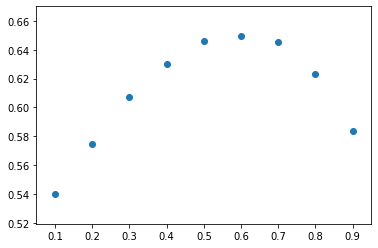

In [19]:
plt.scatter(threshold.tolist(), accuracy)

### When threshold is 0.6, performance on the validation set is the best. Accuracy is about 0.65.

# Question 3

In [20]:
# books and users information in validation set
Books_v = defaultdict(set)
Users_v = defaultdict(set)

for d in validation:
    u_v, b_v = d["userID"], d["bookID"]
    Books_v[u_v].add(b_v)
    Users_v[b_v].add(u_v)

In [21]:
# books and users information in training set
Books_t = defaultdict(set)
Users_t = defaultdict(set)

for d in training:
    u_t, b_t = d["userID"], d["bookID"]
    Books_t[u_t].add(b_t)
    Users_t[b_t].add(u_t)

In [22]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer / denom

In [23]:
similarities = []
for v in validation:
    max_sim = 0

    # book id and user id in the validation set
    book = v["bookID"]
    user = v["userID"]

    # users who have read this book
    users = Users_t[book]

    # loop through every book in the training set that the user has read
    for b2 in Books_t[user]:  # for all books in the training set
        if book == b2:
            continue
        sim = Jaccard(users, Users_t[b2])
        if sim > max_sim:
            max_sim = sim
    similarities.append((book, max_sim))

In [24]:
accuracy = []
threshold = numpy.linspace(0, 0.02, 11)
for x in threshold:

    prediction = []
    for s in similarities:
        if s[1] > x:
            prediction.append("1")
        else:
            prediction.append("0")

    count = 0
    for p in range(0, len(prediction) - 1):
        if p <= 9999:
            if prediction[p] == "1":
                count += 1
        else:
            if prediction[p] == "0":
                count += 1

    acc = count / 20000
    accuracy.append(acc)

In [25]:
df2 = {"Threshold_Q3": threshold, "Accuracy_Q3": accuracy}
table2 = pandas.DataFrame(df2, columns=["Threshold_Q3", "Accuracy_Q3"])
table2

,Threshold_Q3,Accuracy_Q3
0,0.000,0.59070
1,0.002,0.59070
2,0.004,0.59500
3,0.006,0.60375
4,0.008,0.61590
5,0.010,0.62125
6,0.012,0.62020
7,0.014,0.61380
8,0.016,0.59995
9,0.018,0.58745


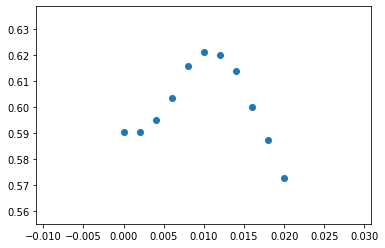

In [26]:
plt.scatter(threshold.tolist(), accuracy)

### When threshold is 0.01, performance on the validation set is the best. Accuracy is about 0.62.

## Question 4

In [27]:
accuracy = []
book_popularity = []
jaccard_similarity = []
threshold_popularity = numpy.linspace(0.1, 0.9, 9)
threshold_jaccard = numpy.linspace(0, 0.02, 11)

# loop through every threshold_popularity and threshold_jaccard
for x in threshold_popularity:

    # get popularity threshold
    return4 = set()
    count = 0
    for ic, i in mostPopular:
        count += ic
        return4.add(i)
        if count > totalRead * (x):
            break

    for y in threshold_jaccard:

        book_popularity.append(x)
        jaccard_similarity.append(y)

        prediction = []
        for s in similarities:
            if s[1] > y and s[0] in return4:
                prediction.append("1")
            else:
                prediction.append("0")

        count = 0
        for p in range(0, len(prediction) - 1):
            if p <= 9999:
                if prediction[p] == "1":
                    count += 1
            else:
                if prediction[p] == "0":
                    count += 1

        acc = count / 20000
        accuracy.append(acc)

In [28]:
df4 = {
    "Popularity Threshold": book_popularity,
    "Jaccard Similarity": jaccard_similarity,
    "Accuracy": accuracy,
}
table4 = pandas.DataFrame(
    df4, columns=["Popularity Threshold", "Jaccard Similarity", "Accuracy"]
)
table4

,Popularity Threshold,Jaccard Similarity,Accuracy
0,0.1,0.000,0.54005
1,0.1,0.002,0.54005
2,0.1,0.004,0.53995
3,0.1,0.006,0.53985
4,0.1,0.008,0.53915
...,...,...,...
94,0.9,0.012,0.63965
95,0.9,0.014,0.62890
96,0.9,0.016,0.61255
97,0.9,0.018,0.59730


In [29]:
table4[table4["Accuracy"] == max(accuracy)]

,Popularity Threshold,Jaccard Similarity,Accuracy
70,0.7,0.008,0.663


### A combination of popularity threshold = 0.7 and jaccard similarity = 0.008 gives the largest accuracy, which is 0.6569.

## Question 5

In [30]:
count = 0
header = "userID-bookID,prediction" + "\n"

# get popularity threshold
return5 = set()
for ic, i in mostPopular:
    count += ic
    return5.add(i)
    if count > totalRead * 0.7:
        break

# get similarity threshold
data = open("pairs_Read.txt", "r")
similarities = []
for l in data:
    if l.startswith("userID-bookID,prediction"):
        continue
    else:
        user_id, book_id = l.strip().split("-")
        max_sim = 0
        users = usersPerBook[book_id]

        for b2 in booksPerUser[user_id]:  # for all books in the training set
            if book_id == b2:
                continue
            sim = Jaccard(users, usersPerBook[b2])
            if sim > max_sim:
                max_sim = sim

        similarities.append((user_id, book_id, max_sim))

# use our model to do prediction
predictions5 = open("predictions_Read5.txt", "w")
predictions5.write(header)

# if both conditions are satisfied, predict as read. Otherwise, predict as not read.
for s in similarities:

    u = s[0]
    b = s[1]
    score = s[2]

    if score > 0.008 and b in return5:
        predictions5.write(u + "-" + b + ",1\n")
    else:
        predictions5.write(u + "-" + b + ",0\n")

predictions5.close()

## Question 9

In [60]:
dataset = list(readCSV("train_Interactions.csv.gz"))

In [61]:
training = dataset[:190000]
validation = dataset[190000:]

In [62]:
usersPerBook_t = defaultdict(dict)
booksPerUser_t = defaultdict(dict)
for u,b,r in training:
    usersPerBook_t[b][u] = r
    booksPerUser_t[u][b] = r

In [63]:
beta_u_new = {}
beta_b_new = {}

for user_id, book_id, rating in training:
    beta_u_new[user_id] = 0
    beta_b_new[book_id] = 0

In [64]:
alpha_l = []
for i in numpy.arange(1, 10):
    
    # loop through the training set to calculate alpha
    sum_a = 0
    for user_id, book_id, rating in training:
        sum_a = sum_a + float(rating) - float(beta_u_new[user_id]) - float(beta_b_new[book_id])
    alpha = sum_a/len(training)
    alpha_l.append(alpha)
    
    # loop through the user list
    for u in booksPerUser_t:
        # loop though book that this user has rated in usersPerBook_t and calculate beta_u
        sum_u = 0
        for b in booksPerUser_t[u]:
            sum_u = sum_u + float(booksPerUser_t[u][b]) - alpha - float(beta_b_new[b])
        beta_u = sum_u/(1+len(booksPerUser_t[u]))
        beta_u_new[u] = beta_u
    
    # loop through the book list
    for b in usersPerBook_t:
        # loop though every user that has rated this book in booksPerUser_t and calculate beta_b
        sum_b = 0
        for u in usersPerBook_t[b]:
            sum_b = sum_b + float(usersPerBook_t[b][u]) - alpha - float(beta_u_new[u])
        beta_b = sum_b/(1+len(usersPerBook_t[b]))
        beta_b_new[b] = beta_b

In [65]:
alpha_l

[3.897121052631579,
 3.894423774004082,
 3.891519920259996,
 3.888678189696154,
 3.885929281770858,
 3.883271619649327,
 3.88070034659372,
 3.878211267964131,
 3.875801015770858]

In [66]:
alpha

3.875801015770858

In [16]:
beta_b_new

{'b14275065': 0.007167642728519154,
 'b82152306': 0.2669451580103152,
 'b44882292': 0.16773985133105881,
 'b79927466': -0.031215475703764255,
 'b05683889': 0.593427244893,
 'b86375465': -0.21655745377693797,
 'b92838791': 0.107380151426121,
 'b35165110': 0.31778758657990824,
 'b17128180': 0.32705124023505155,
 'b34596567': 0.24941284141591274,
 'b23506537': -0.21838475114257894,
 'b95176169': 0.23017771467613743,
 'b03231083': -0.06622565262482405,
 'b20090710': -0.018224590820990486,
 'b62660670': -0.5188105681148124,
 'b01071719': 0.2017138107214198,
 'b99816042': -0.11719251990346355,
 'b79202035': -0.4909273837752968,
 'b39996061': 0.1388411555304495,
 'b15891222': 0.3581506734016647,
 'b01287078': -0.0016353329489469572,
 'b19581977': 0.10373933094316731,
 'b80735440': 0.105383383672309,
 'b29820018': -0.007044029581789726,
 'b57056376': 0.11569302165317964,
 'b50835324': 0.1663691209186947,
 'b46969785': -0.05156836305712942,
 'b30423629': 0.09291628983829175,
 'b63987437': -0.37

In [67]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [68]:
pre_rating = list()
real_rating = list()

for user_id, book_id, rating in validation:
    real_rating.append(float(rating))
    
    if user_id in beta_u_new:
        if book_id in beta_b_new:
            pred = alpha + float(beta_u_new[user_id]) + float(beta_b_new[book_id])
        else:
            pred = alpha + float(beta_u_new[user_id])
    else:
        if book_id in beta_b_new:
            pred = alpha + float(beta_u_new[user_id])
        else:
            pred = alpha
    
    pre_rating.append(float(pred))

MSE(pre_rating, real_rating)

1.115954110564234

In [37]:
training = dataset[:1900000]
validation = dataset[190000:]

reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

for d in training:
    user, item = d['userID'], d['bookID']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)

In [38]:
Avg = numpy.sum([d['rating'] for d in training])/len(training)
alpha = Avg
labels = [d['rating'] for d in training]

In [39]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return numpy.sum(differences) / len(differences)

In [40]:
N = len(training)
nUsers = len(reviewsPerUser)
nItems = len(reviewsPerItem)
users = list(reviewsPerUser.keys())
items = list(reviewsPerItem.keys())

In [41]:
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

In [42]:
def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

In [43]:
def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))

In [44]:
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(d['userID'], d['bookID']) for d in training]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

In [45]:
def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(training)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for d in training:
        u,i = d['userID'], d['bookID']
        pred = prediction(u, i)
        diff = pred - d['rating']
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return numpy.array(dtheta)

In [46]:
x = scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, 1))

MSE = 1.4744154699750003
MSE = 1.457031916999616
MSE = 1.4742591547263286
MSE = 1.474259152327243


In [47]:
x

(array([ 3.89672691e+00, -9.32102553e-06,  6.71757987e-05, ...,
        -8.45113321e-06, -1.79354995e-05, -9.48354249e-06]),
 1.4743372997616107,
 {'grad': array([-2.46580589e-08, -3.28001861e-09, -1.07118594e-08, ...,
         -1.01363148e-09, -1.48604949e-09, -4.72924369e-10]),
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 4,
  'nit': 2,
  'warnflag': 0})

In [48]:
a = x[0][0]
userBiases1 = list(x[0][1:nUsers+1])
itemBiases1 = list(x[0][1+nUsers:])
for i in validation:
    u = i['userID']
    b = i['bookID']
    rating = a
    if u in users:
        rating += userBiases1[users.index(u)]
    if b in items:
        rating += itemBiases1[items.index(b)]
    i['prediction1'] = rating
pred_rating = []
actual_rating = []
for i in validation:
    pred_rating.append(i['prediction1'])
    actual_rating.append(i['rating'])
MSE(pred_rating, actual_rating)

1.4907447321601606

## Question 10

In [69]:
beta_u_large = 0
beta_u_small = 10000

key_list_u = list(beta_u_new.keys()) 
val_list_u = list(beta_u_new.values())

for key in beta_u_new:
    if(beta_u_new[key]) > beta_u_large:
        beta_u_large = beta_u_new[key]
    if(beta_u_new[key]) < beta_u_small:
        beta_u_small = beta_u_new[key]  

large_u = key_list_u[val_list_u.index(beta_u_large)]
small_u = key_list_u[val_list_u.index(beta_u_small)]

print("User ID that have the largest beta: " + str(large_u))
print("Largest beta: " + str(beta_u_large))
print("User ID that have the smallest beta: " + str(small_u))
print("Smallest beta: " + str(beta_u_small))

User ID that have the largest beta: u32162993
Largest beta: 1.3177361735246653
User ID that have the smallest beta: u48313610
Smallest beta: -3.75158518482816


In [70]:
beta_b_large = 0
beta_b_small = 10000

key_list_b = list(beta_b_new.keys()) 
val_list_b = list(beta_b_new.values())

for key in beta_b_new:
    if(beta_b_new[key]) > beta_b_large:
        beta_b_large = beta_b_new[key]
    if(beta_b_new[key]) < beta_b_small:
        beta_b_small = beta_b_new[key] 

large_b = key_list_b[val_list_b.index(beta_b_large)]
small_b = key_list_b[val_list_b.index(beta_b_small)]

print("Book ID that have the largest beta: " + str(large_b))
print("Largest beta: " + str(beta_b_large))
print("Book ID that have the smallest beta: " + str(small_b))
print("Smallest beta: " + str(beta_b_small))

Book ID that have the largest beta: b19925500
Largest beta: 1.3704645510034998
Book ID that have the smallest beta: b84091840
Smallest beta: -1.8123584943010929


## Question 11

In [123]:
dataset = list(readCSV("train_Interactions.csv.gz"))

In [124]:
training = dataset[:190000]
validation = dataset[190000:]

In [125]:
usersPerBook_t = defaultdict(dict)
booksPerUser_t = defaultdict(dict)
for u,b,r in training:
    usersPerBook_t[b][u] = r
    booksPerUser_t[u][b] = r

In [126]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [127]:
lmd_l = []
mse_l = []

# different values of lambda
for l1 in numpy.linspace(2, 3, 2):
    for l2 in numpy.linspace(13, 15, 3):
        print('lambda: ' + str(l1) + ',' + str(l2))
        lmd_l.append((l1, l2))

        # initialize beta dictionary
        beta_u_new = {}
        beta_b_new = {}

        for user_id, book_id, rating in training:
            beta_u_new[user_id] = 0
            beta_b_new[book_id] = 0
    
        for i in range(1, 10):
    
            # loop through the training set to calculate alpha
            sum_a = 0
            for user_id, book_id, rating in training:
                sum_a = sum_a + float(rating) - float(beta_u_new[user_id]) - float(beta_b_new[book_id])
            alpha = sum_a/len(training)
    
            # loop through the user list
            for u in booksPerUser_t:
                # loop though book that this user has rated in usersPerBook_t and calculate beta_u
                sum_u = 0
                for b in booksPerUser_t[u]:
                    sum_u = sum_u + float(booksPerUser_t[u][b]) - alpha - float(beta_b_new[b])
                beta_u = sum_u/(l1+len(booksPerUser_t[u]))
                beta_u_new[u] = beta_u
    
            # loop through the book list
            for b in usersPerBook_t:
                # loop though every user that has rated this book in booksPerUser_t and calculate beta_b
                sum_b = 0
                for u in usersPerBook_t[b]:
                    sum_b = sum_b + float(usersPerBook_t[b][u]) - alpha - float(beta_u_new[u])
                beta_b = sum_b/(l2+len(usersPerBook_t[b]))
                beta_b_new[b] = beta_b
    
        # predict rating in the validation set
        pre_rating = list()
        real_rating = list()
    
        for user_id, book_id, rating in validation:
            real_rating.append(float(rating))
    
            if user_id in beta_u_new:
                if book_id in beta_b_new:
                    pred = alpha + float(beta_u_new[user_id]) + float(beta_b_new[book_id])
                else:
                    pred = alpha + float(beta_u_new[user_id])
            else:
                if book_id in beta_b_new:
                    pred = alpha + float(beta_u_new[user_id])
                else:
                    pred = alpha
    
            pre_rating.append(float(pred))

        # calculate MSE for each lambda
        mse = MSE(pre_rating, real_rating)
        mse_l.append(mse)
        print('MSE: ' + str(mse))

lambda: 2.0,13.0
MSE: 1.0960728961026702
lambda: 2.0,14.0
MSE: 1.0958655560635908
lambda: 2.0,15.0
MSE: 1.095718814204338
lambda: 3.0,13.0
MSE: 1.0972879981397496
lambda: 3.0,14.0
MSE: 1.097059435415495
lambda: 3.0,15.0
MSE: 1.0968923822860044


In [14]:
for l in numpy.linspace(2, 4, 3):
    print(l)

2.0
3.0
4.0


In [128]:
min_mse = min(mse_l)
print("Minimum MSE is: " + str(min_mse))

min_index = mse_l.index(min_mse)
min_lambda = lmd_l[min_index]
print("corresponding lambda: " + str(min_lambda))

Minimum MSE is: 1.095718814204338
corresponding lambda: (2.0, 15.0)


In [129]:
# get alpha, beta_u and beta_i when lambda is 3
beta_u_best = {}
beta_b_best = {}

for user_id, book_id, rating in training:
    beta_u_best[user_id] = 0
    beta_b_best[book_id] = 0
    
for i in range(1, 10):
    
    # loop through the training set to calculate alpha
    sum_a = 0
    for user_id, book_id, rating in training:
        sum_a = sum_a + float(rating) - float(beta_u_best[user_id]) - float(beta_b_best[book_id])
    alpha_best = sum_a/len(training)
    
        # loop through the user list
    for u in booksPerUser_t:
        # loop though book that this user has rated in usersPerBook_t and calculate beta_u
        sum_u = 0
        for b in booksPerUser_t[u]:
            sum_u = sum_u + float(booksPerUser_t[u][b]) - alpha_best - float(beta_b_best[b])
        beta_u = sum_u/(2+len(booksPerUser_t[u]))
        beta_u_best[u] = beta_u
    
    # loop through the book list
    for b in usersPerBook_t:
        # loop though every user that has rated this book in booksPerUser_t and calculate beta_b
        sum_b = 0
        for u in usersPerBook_t[b]:
            sum_b = sum_b + float(usersPerBook_t[b][u]) - alpha_best - float(beta_u_best[u])
        beta_b = sum_b/(13+len(usersPerBook_t[b]))
        beta_b_best[b] = beta_b

In [130]:
users = list()
books = list()
ratings = list()
count = 0

# get user_id and book_id from file
data = open("pairs_Rating.txt", "r")
for l in data:
    if l.startswith("userID-bookID,prediction"):
        continue
    # get user_id and book_id
    else:
        user_id, book_id = l.strip().split("-")
        count = count + 1
    
    # predict rating
    if user_id in beta_u_best:
        if book_id in beta_b_best:
            pred = alpha_best + float(beta_u_best[user_id]) + float(beta_b_best[book_id])
        else:
            pred = alpha_best + float(beta_u_new[user_id])
    else:
        if book_id in beta_b_best:
            pred = alpha_best + float(beta_u_best[user_id])
        else:
            pred = alpha_best
    
    users.append(user_id)
    books.append(book_id)
    ratings.append(pred)
    
# use our model to do prediction
predictions9 = open("predictions_Rating.txt", "w")
header = "userID-bookID,prediction" + "\n"
predictions9.write(header)

for i in range(0, count):
    predictions9.write(users[i] + "-" + books[i] + "," + str(ratings[i]) + "\n")

predictions9.close()